In [3]:
import os
import glob
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
torch.cuda.set_device(0)

Previous device? 0
Is cuda available? True
Is cuDNN version: 8700
cuDNN enabled?  True
Device count? 2
Current device? 0


## Load in the dataset

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature_path = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        X = torch.load(feature_path)[0,:,:]
        y = torch.FloatTensor([float(label) for label in literal_eval(self.labels.iloc[idx, 1])]).to(device)
        if self.transform:
            embedding = self.transform(embedding)
        return X, y
    
sequence_dataset = SequenceDataset(csv_file='/home/vera/projects/masters_project/data/rmsd_dataset.csv', root_dir='/home/vera/projects/masters_project/data/s-pred_features/')

print(sequence_dataset[1][0].shape, sequence_dataset[1][1].shape)

torch.Size([329, 1056]) torch.Size([329])


In [7]:
DATASET_SIZE = 500

sequence_dataset = SequenceDataset(csv_file='/home/vera/projects/masters_project/data/rmsd_dataset.csv',
                                    root_dir='/home/vera/projects/masters_project/data/s-pred_features/')
indices = np.random.choice(len(sequence_dataset), DATASET_SIZE, replace=False)
sequence_dataset = torch.utils.data.Subset(sequence_dataset, indices)

train_size = int(0.8 * len(sequence_dataset))
val_size = int(0.1 * len(sequence_dataset))
test_size = len(sequence_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(sequence_dataset, [train_size, val_size, test_size])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 160
Validation dataset size: 20
Test dataset size: 20


In [8]:
class ResidueDataset(Dataset):
    def __init__(self, sequence_dataset, transform=None):
        self.embeddings = []
        self.labels = []
        for i in range(len(sequence_dataset)):
            sequence = sequence_dataset[i]
            for j in range(sequence[1].shape[0]):
                self.embeddings.append(sequence[0][j,:])
                self.labels.append(sequence[1][j].to(device))
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        X = self.embeddings[idx]
        y = int(self.labels[idx] >= RMSD_THRESHOLD)
        return X,y

In [9]:
# Create the subsets
train_residues = ResidueDataset(sequence_dataset=train_dataset)
val_residues = ResidueDataset(sequence_dataset=val_dataset)
test_residues = ResidueDataset(sequence_dataset=test_dataset)
# Create a dataset of all the residues by concatenating the train, validation and test sets
all_residues = torch.utils.data.ConcatDataset([train_residues, val_residues, test_residues])

torch.cuda.empty_cache()

print(len(train_dataset), len(train_residues))
print(len(val_dataset), len(val_residues))
print(len(test_dataset), len(test_residues))

for i in range(5):
    print(train_residues[i][0][:5], train_residues[i][1])

160 47831
20 5834
20 5768
tensor([-1.0288,  0.5436, -0.4814, -0.1359, -1.1904], device='cuda:0') 0
tensor([-0.2479,  0.2281,  0.9112,  0.2223, -1.0354], device='cuda:0') 0
tensor([-1.1235, -0.1122, -0.3922, -0.7525, -0.6934], device='cuda:0') 1
tensor([-0.0104, -1.0341, -0.1038,  0.3533, -0.8593], device='cuda:0') 1
tensor([-0.2670, -0.3542, -0.8596, -0.4766, -1.1598], device='cuda:0') 1


## Create the model

In [18]:
# Define a binary classifier with five hidden layers
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        #  Add batch normalization layers
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)


    def forward(self, x, training=True):

        self.training = training

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)

        return x

## Train the model

In [25]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 128
CLASS_WEIGHTS = [1, 1]

# Create the dataloaders
train_loader = DataLoader(train_residues, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_residues, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_residues, batch_size=BATCH_SIZE, shuffle=True)

model = SimpleClassifier()
#model = ImprovedClassifier()
model.cuda()

# Create a class weight tensor
class_weights = torch.FloatTensor(CLASS_WEIGHTS).cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model

train_losses = []
val_losses = []
accuracy_per_epoch = []

zero_guess = 0

for epoch in range(EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Train the model
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()[:,:768]
        labels = labels.cuda()
        output = model(features, training=True).cuda()
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*features.size(0)
        
    # Evaluate the model
    model.eval()
    for i, (features, labels) in enumerate(val_loader):
        features = features.cuda()[:,:768]
        labels = labels.cuda()
        with torch.no_grad():
            output = model(features, training=False)
        loss = criterion(output, labels)
        val_loss += loss.item()*features.size(0)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if epoch == 0:
            zero_guess += (labels == 0).sum().item()

    accuracy_per_epoch.append(correct/total)
        
    # Print the loss and accuracy, as well as the accuracy when all residues are predicted to be below the threshold
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = val_loss/len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.2%} \tZero Guess: {:.2%}'.format(
        epoch+1,
        train_loss,
        val_loss,
        correct/total,
        zero_guess/total
        ))

Epoch: 1 	Training Loss: 0.491176 	Validation Loss: 0.460942 	Accuracy: 80.42% 	Zero Guess: 80.28%
Epoch: 2 	Training Loss: 0.432427 	Validation Loss: 0.466309 	Accuracy: 79.73% 	Zero Guess: 80.28%
Epoch: 3 	Training Loss: 0.402628 	Validation Loss: 0.469600 	Accuracy: 79.12% 	Zero Guess: 80.28%
Epoch: 4 	Training Loss: 0.376067 	Validation Loss: 0.487702 	Accuracy: 78.14% 	Zero Guess: 80.28%
Epoch: 5 	Training Loss: 0.350520 	Validation Loss: 0.520475 	Accuracy: 77.11% 	Zero Guess: 80.28%
Epoch: 6 	Training Loss: 0.326296 	Validation Loss: 0.523206 	Accuracy: 77.07% 	Zero Guess: 80.28%
Epoch: 7 	Training Loss: 0.302731 	Validation Loss: 0.544688 	Accuracy: 77.00% 	Zero Guess: 80.28%
Epoch: 8 	Training Loss: 0.276959 	Validation Loss: 0.594002 	Accuracy: 78.08% 	Zero Guess: 80.28%
Epoch: 9 	Training Loss: 0.255062 	Validation Loss: 0.593891 	Accuracy: 77.07% 	Zero Guess: 80.28%
Epoch: 10 	Training Loss: 0.234248 	Validation Loss: 0.652105 	Accuracy: 76.33% 	Zero Guess: 80.28%


KeyboardInterrupt: 

## Plot the accuracy curve

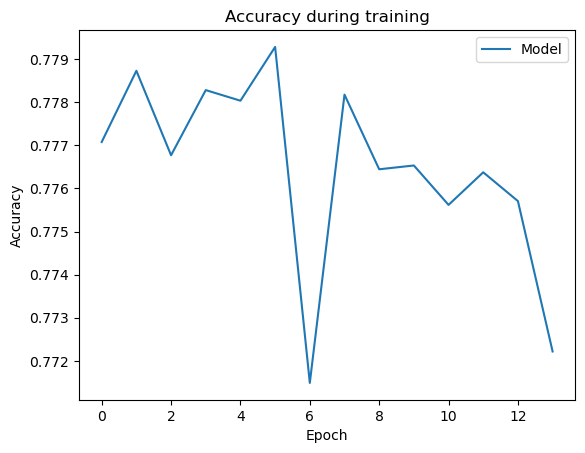

In [14]:

# Plot the accuracy per epoch in percentages
plt.plot(accuracy_per_epoch)
#plt.plot([zero_guess/total]*EPOCHS)
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 13, 2))
plt.legend(['Model', 'Zero Guess'])
plt.show()

## Plot the loss curve

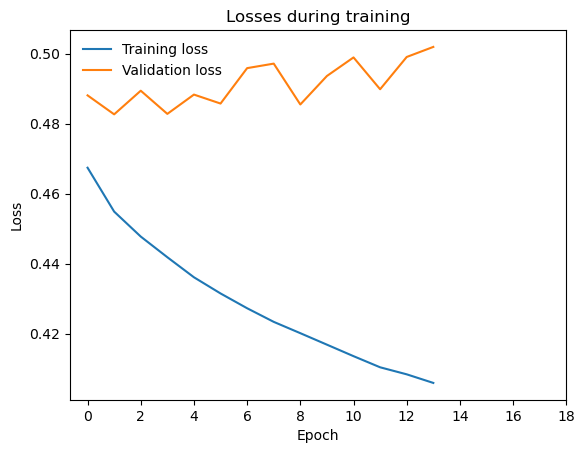

In [15]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Losses during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
# Set the x ticks to be every 5 epochs
plt.xticks(np.arange(0, EPOCHS, 2))
plt.show()

## Calculate the accuracy, precision, recall and F1 score

In [126]:
# Test the accuracy of the model on the train set
correct = 0
total = 0
with torch.no_grad():
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Train set accuracy:   %d %%' % (100 * correct / total))

# Test the accuracy, precision, recall and F1 score of the model
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        for j in range(len(labels)):
            if labels[j] == 0 and predicted[j] == 0:
                true_negative += 1
            elif labels[j] == 1 and predicted[j] == 0:
                false_negative += 1
            elif labels[j] == 1 and predicted[j] == 1:
                true_positive += 1
            elif labels[j] == 0 and predicted[j] == 1:
                false_positive += 1

print('Test set accuracy:    %d %%' % (100 * (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)))
print('Test set precision:   %d %%' % (100 * true_positive / (true_positive + false_positive)))
print('Test set recall:      %d %%' % (100 * true_positive / (true_positive + false_negative)))
print('Test set F1 score     %d %%' % (100 * 2 * true_positive / (2 * true_positive + false_positive + false_negative)))


Train set accuracy:   96 %
Test set accuracy:    75 %
Test set precision:   40 %
Test set recall:      31 %
Test set F1 score     35 %


## Plot a confusion matrix

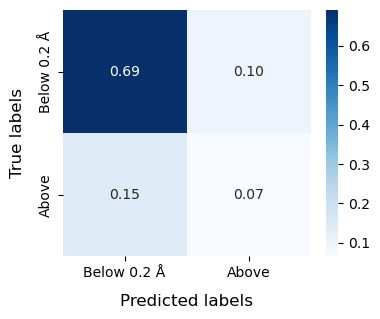

In [112]:
# Confusion matrix using percentages
y_true = []
y_pred = []

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        for j in range(len(labels)):
            y_true.append(labels[j].item())
            y_pred.append(predicted[j].item())

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=(0,1))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 3.2))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=ax)

# Labels, title and ticks. Make the labels bigger
ax.set_xlabel('Predicted labels', fontsize=12, labelpad=10)
ax.set_ylabel('True labels', fontsize=12, labelpad=10)
#ax.set_title('Confusion Matrix')


ax.xaxis.set_ticklabels(['Below ' + str(RMSD_THRESHOLD) + ' Å', 'Above'])
ax.yaxis.set_ticklabels(['Below ' + str(RMSD_THRESHOLD) + ' Å', 'Above'])


# Show the confusion matrix
plt.show()

## Plot the per-residue accuracy for 5 proteins

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

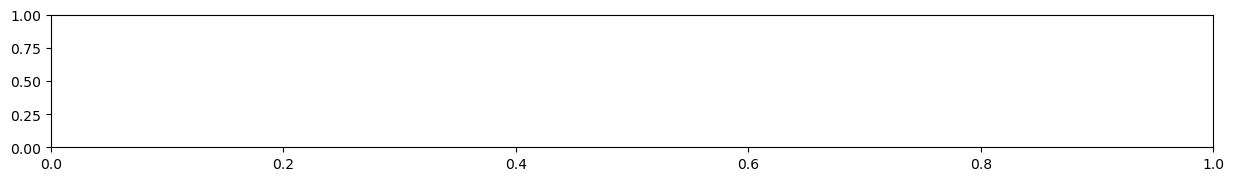

In [178]:

fig = plt.figure(figsize=(15, 10))

for i in range(5):
    # Add subplot vertically
    ax = fig.add_subplot(5, 1, i+1)

    # Test for a single protein
    test_protein = test_dataset[random.randint(0, len(test_dataset))]

    # Get the predicted labels for each residue
    predicted_labels = []
    with torch.no_grad():
        for residue in test_protein[0]:
            residue = residue.cuda()
            residue = residue.unsqueeze(0)
            output = model(residue).cpu()
            _, predicted = torch.max(output.data, 1)
            predicted_labels.append(predicted.item()*RMSD_THRESHOLD)

    # Get the actual labels for each residue
    actual_labels = []
    correct_labels = []
    for residue in test_protein[1]:
        actual_labels.append(residue.cpu())
        correct_labels.append(int(residue >= RMSD_THRESHOLD))

    # Get a list of correctly predicted labels
    correctly_predicted_labels = []
    for i in range(len(predicted_labels)):
        if correct_labels[i] == 1 and predicted_labels[i] == RMSD_THRESHOLD:
            correctly_predicted_labels.append(RMSD_THRESHOLD)
        elif correct_labels[i] == 0 and predicted_labels[i] == 0:
            correctly_predicted_labels.append(0)
        else:
            correctly_predicted_labels.append(None)
  
    ax.plot(actual_labels, color='black')
    ax.plot(predicted_labels, color='red', marker='o', linestyle='None', markersize=4)
    ax.plot(correctly_predicted_labels, color='green', marker='o', linestyle='None', markersize=4)
    ax.set_ylim(0, RMSD_THRESHOLD*5)
    ax.fill_between(range(len(actual_labels)), actual_labels, color='black', alpha=0.2)

plt.show()


    